In [ ]:
import sklearn
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [3]:
from datasets import load_dataset

ds = load_dataset("Nooha/cc_fraud_detection_dataset")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Cleaning 

I have performed the following cleaning steps after converting the data set to a pandas df. 
* remove missing values 
* drop duplicates 
* drop irrelevant columns (simplifies it for our model training and testing stage)
* applying one-hot encoding to categorical columns 
* converting date time for more suitable format for machine learning. 

In [4]:
#converting it to a pandas df instead 
df = ds['train'].to_pandas()

# checking basic info
print(df.info())
print(df.head()) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2646694 entries, 0 to 2646693
Data columns (total 20 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ssn         object 
 1   cc_num      int64  
 2   first       object 
 3   last        object 
 4   gender      object 
 5   city        object 
 6   state       object 
 7   zip         int64  
 8   city_pop    int64  
 9   job         object 
 10  dob         object 
 11  acct_num    int64  
 12  trans_num   object 
 13  trans_date  object 
 14  trans_time  object 
 15  unix_time   int64  
 16  category    object 
 17  amt         float64
 18  is_fraud    int64  
 19  merchant    object 
dtypes: float64(1), int64(6), object(13)
memory usage: 403.9+ MB
None
           ssn            cc_num    first   last gender      city state  \
0  367-85-9826  4361337605230458  Kristie  Davis      F  Chandler    OK   
1  367-85-9826  4361337605230458  Kristie  Davis      F  Chandler    OK   
2  367-85-9826  4361337605230458  Kristie 

In [5]:
#check for missing values 
print(df.isnull().sum())

#drop duplicates and check new dataset size
print("Original size:", df.shape)  # (rows, columns)
df.drop_duplicates(inplace=True)
print("New size after dropping duplicates:", df.shape) 
# NO DUPLICATES FOUND 

# drop irrelvant columns 
columns_to_drop = ['ssn', 'first', 'last', 'trans_num', 'dob', 'acct_num']
df = df.drop(columns=columns_to_drop)


# applying one-hot encoding to categorical columns 
#categorical_columns = ['gender', 'city', 'state', 'job', 'category', 'merchant']
#df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


# converting date time for more suitable format for machine learning. 
#df['trans_date'] = pd.to_datetime(df['trans_date'], errors='coerce')

# extract year, month, and day
#df['trans_date_year'] = df['trans_date'].dt.year
#df['trans_date_month'] = df['trans_date'].dt.month
#df['trans_date_day'] = df['trans_date'].dt.day

# drop the original trans_date column
#df = df.drop(columns=['trans_date'])

# convert trans_time to hour of the day
#df['trans_time'] = pd.to_datetime(df['trans_time'], format='%H:%M:%S').dt.hour




ssn           0
cc_num        0
first         0
last          0
gender        0
city          0
state         0
zip           0
city_pop      0
job           0
dob           0
acct_num      0
trans_num     0
trans_date    0
trans_time    0
unix_time     0
category      0
amt           0
is_fraud      0
merchant      0
dtype: int64
Original size: (2646694, 20)
New size after dropping duplicates: (2646694, 20)


In [6]:
total_fraud_cases = df[df['is_fraud'] == 1].shape[0]
print("Total fraud cases:", total_fraud_cases)

Total fraud cases: 9422


# Some EDA

* summary statistics 
* distribution (we need SMOTE) 
* categorical/time-based/city population spread of fraud 
* correlation heatmap

In [7]:
# Summary statistics for numerical features
print(df.describe())

             cc_num           zip      city_pop     unix_time           amt  \
count  2.646694e+06  2.646694e+06  2.646694e+06  2.646694e+06  2.646694e+06   
mean   4.029946e+17  5.231005e+04  2.856760e+05  1.658489e+09  7.011208e+01   
std    1.284962e+18  2.982117e+04  5.735517e+05  2.735784e+07  1.664218e+02   
min    6.040027e+10  1.040000e+03  1.410000e+02  1.609439e+09  1.000000e+00   
25%    3.852401e+13  2.915300e+04  1.639500e+04  1.634951e+09  9.120000e+00   
50%    3.505313e+15  4.920200e+04  5.777400e+04  1.658633e+09  4.461000e+01   
75%    4.544118e+15  7.853700e+04  2.280950e+05  1.682763e+09  8.169000e+01   
max    4.997335e+18  9.970100e+04  2.906700e+06  1.704047e+09  4.301981e+04   

           is_fraud  
count  2.646694e+06  
mean   3.559913e-03  
std    5.955872e-02  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.000000e+00  


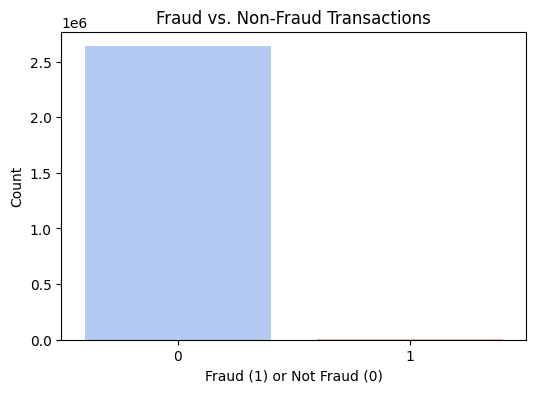

Fraud cases percentage: 0.36%


In [8]:
import seaborn as sns

# distribution of fraud
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='is_fraud', hue='is_fraud', palette='coolwarm', legend=False)
plt.title("Fraud vs. Non-Fraud Transactions")
plt.xlabel("Fraud (1) or Not Fraud (0)")
plt.ylabel("Count")
plt.show()

# percentage of fraud cases
fraud_percentage = df['is_fraud'].mean() * 100
print(f"Fraud cases percentage: {fraud_percentage:.2f}%")


we need SMOTE bc no. of fraud cases are too little 

In [9]:
print(df.columns)

Index(['cc_num', 'gender', 'city', 'state', 'zip', 'city_pop', 'job',
       'trans_date', 'trans_time', 'unix_time', 'category', 'amt', 'is_fraud',
       'merchant'],
      dtype='object')


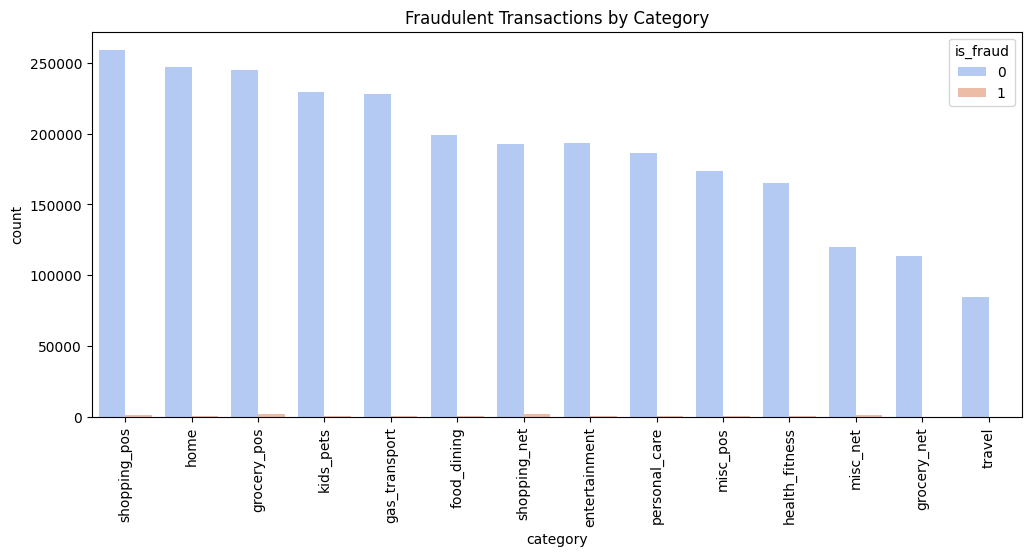

Fraud cases and percentage by category:
                Fraud Cases  Fraud Percentage
category                                     
shopping_net           2251          1.154531
grocery_pos            2205          0.892550
misc_net               1201          0.993852
shopping_pos           1097          0.421529
gas_transport           703          0.306866
entertainment           302          0.156057
misc_pos                290          0.166678
personal_care           261          0.139757
kids_pets               236          0.102737
home                    212          0.085584
food_dining             209          0.104848
health_fitness          163          0.098728
grocery_net             157          0.137750
travel                  135          0.159936


In [10]:
#fraud by category 
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='category', hue='is_fraud', order=df['category'].value_counts().index, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Fraudulent Transactions by Category")
plt.show()

# fraud count and percentage per category
fraud_counts = df[df['is_fraud'] == 1]['category'].value_counts()
total_counts = df['category'].value_counts()
fraud_percentage = (fraud_counts / total_counts * 100).fillna(0)

# in df format
fraud_summary = pd.DataFrame({'Fraud Cases': fraud_counts, 'Fraud Percentage': fraud_percentage})
fraud_summary = fraud_summary.sort_values(by='Fraud Cases', ascending=False)

print("Fraud cases and percentage by category:")
print(fraud_summary)


In [20]:
fraud_df = df[df['is_fraud'] == 1].copy()

# convert and extract hour
fraud_df['trans_time'] = pd.to_datetime(fraud_df['trans_time'], format='%H:%M:%S').dt.time
fraud_df['hour'] = fraud_df['trans_time'].apply(lambda x: x.hour)

# count frauds by hour
fraud_count_by_hour = fraud_df['hour'].value_counts().sort_index()

# create a complete range of hours (0-23)
all_hours = pd.Series(np.zeros(24), index=range(24))
fraud_count_by_hour = fraud_count_by_hour.add(all_hours, fill_value=0)

# display the count of fraud by hour
print("Fraud Count by Hour:")
for hour, count in fraud_count_by_hour.items():
    print(f"Hour {hour}: {int(count)} frauds")

# create and display in df
fraud_hourly_df = pd.DataFrame({
    'Hour': fraud_count_by_hour.index,
    'Fraud_Count': fraud_count_by_hour.values
})

print("\nFraud Count DataFrame:")
print(fraud_hourly_df)



Fraud Count by Hour:
Hour 0: 852 frauds
Hour 1: 855 frauds
Hour 2: 845 frauds
Hour 3: 872 frauds
Hour 4: 67 frauds
Hour 5: 59 frauds
Hour 6: 68 frauds
Hour 7: 62 frauds
Hour 8: 68 frauds
Hour 9: 59 frauds
Hour 10: 66 frauds
Hour 11: 61 frauds
Hour 12: 90 frauds
Hour 13: 83 frauds
Hour 14: 88 frauds
Hour 15: 104 frauds
Hour 16: 87 frauds
Hour 17: 104 frauds
Hour 18: 78 frauds
Hour 19: 93 frauds
Hour 20: 89 frauds
Hour 21: 102 frauds
Hour 22: 2318 frauds
Hour 23: 2252 frauds

Fraud Count DataFrame:
    Hour  Fraud_Count
0      0        852.0
1      1        855.0
2      2        845.0
3      3        872.0
4      4         67.0
5      5         59.0
6      6         68.0
7      7         62.0
8      8         68.0
9      9         59.0
10    10         66.0
11    11         61.0
12    12         90.0
13    13         83.0
14    14         88.0
15    15        104.0
16    16         87.0
17    17        104.0
18    18         78.0
19    19         93.0
20    20         89.0
21    21      

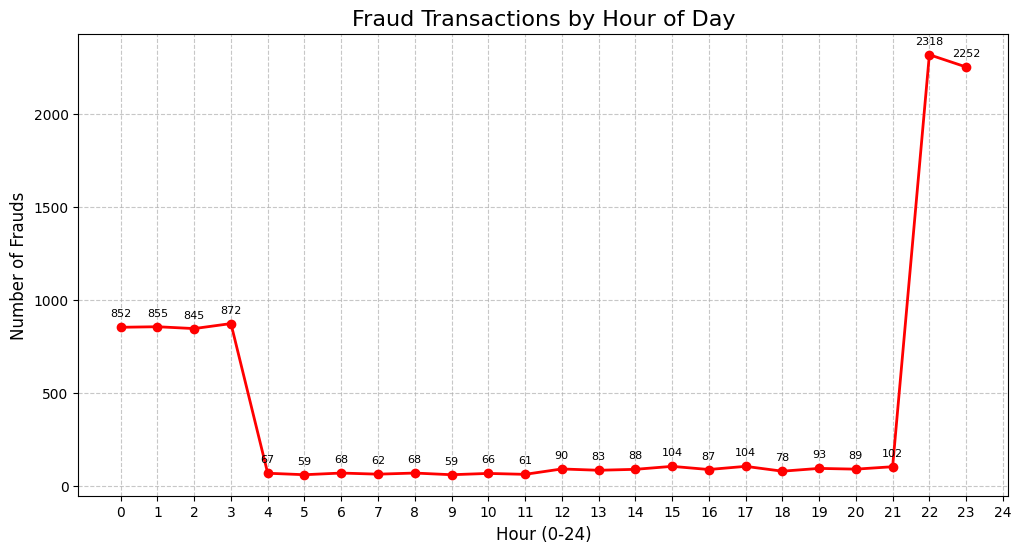

In [21]:

# plot the results as a line plot
plt.figure(figsize=(12, 6))
plt.plot(fraud_hourly_df['Hour'], fraud_hourly_df['Fraud_Count'], 
         marker='o', linestyle='-', color='red', linewidth=2)

# set x-axis ticks to show all hours
plt.xticks(range(25))

# add title and labels
plt.title("Fraud Transactions by Hour of Day", fontsize=16)
plt.xlabel("Hour (0-24)", fontsize=12)
plt.ylabel("Number of Frauds", fontsize=12)

# add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# add data point values
for x, y in zip(fraud_hourly_df['Hour'], fraud_hourly_df['Fraud_Count']):
    plt.text(x, y+max(fraud_hourly_df['Fraud_Count'])*0.02, f'{int(y)}', 
             ha='center', va='bottom', fontsize=8)

 explore fraud over weekends vs weekdays (plot fruad across the days of the week)

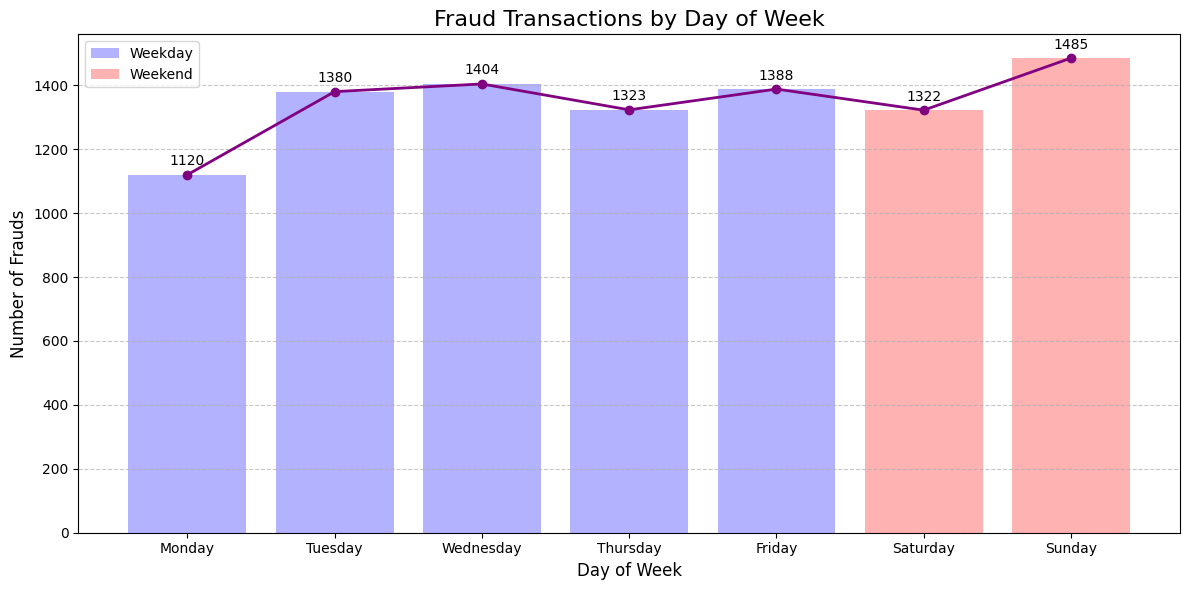

Total Weekday Frauds: 6615
Total Weekend Frauds: 2807
Weekday Average (per day): 1323.00
Weekend Average (per day): 1403.50


In [22]:



# Convert trans_date from object to datetime
fraud_df['trans_date'] = pd.to_datetime(fraud_df['trans_date'], format='%Y-%m-%d')

# Create a new column that indicates the day of the week (0 = Monday, 6 = Sunday)
fraud_df['day_of_week'] = fraud_df['trans_date'].dt.dayofweek
fraud_df['day_name'] = fraud_df['trans_date'].dt.day_name()

# Count frauds by day of week
fraud_count_by_day = fraud_df['day_of_week'].value_counts().sort_index()

# Ensure all days are represented (0-6)
all_days = pd.Series(np.zeros(7), index=range(7))
fraud_count_by_day = fraud_count_by_day.add(all_days, fill_value=0)

# Create a DataFrame for the plot with day names
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fraud_daily_df = pd.DataFrame({
    'Day_Number': fraud_count_by_day.index,
    'Day_Name': days,
    'Fraud_Count': fraud_count_by_day.values,
    'Is_Weekend': [0, 0, 0, 0, 0, 1, 1]  # 0 for weekday, 1 for weekend
})

# Plot fraud count by day of week
plt.figure(figsize=(12, 6))

# Set different colors for weekdays and weekends
colors = ['blue' if is_weekend == 0 else 'red' for is_weekend in fraud_daily_df['Is_Weekend']]

plt.plot(fraud_daily_df['Day_Name'], fraud_daily_df['Fraud_Count'], 
         marker='o', linestyle='-', color='purple', linewidth=2)

# Add bars with different colors for weekday/weekend
plt.bar(fraud_daily_df['Day_Name'], fraud_daily_df['Fraud_Count'], 
        alpha=0.3, color=colors)

# Add title and labels
plt.title("Fraud Transactions by Day of Week", fontsize=16)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Number of Frauds", fontsize=12)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', alpha=0.3, label='Weekday'),
    Patch(facecolor='red', alpha=0.3, label='Weekend')
]
plt.legend(handles=legend_elements)

# Add value labels above each bar
for i, count in enumerate(fraud_daily_df['Fraud_Count']):
    plt.text(i, count + max(fraud_daily_df['Fraud_Count'])*0.02, f'{int(count)}', 
             ha='center', fontsize=10)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

# Print summary of weekday vs weekend
weekday_fraud = fraud_daily_df[fraud_daily_df['Is_Weekend'] == 0]['Fraud_Count'].sum()
weekend_fraud = fraud_daily_df[fraud_daily_df['Is_Weekend'] == 1]['Fraud_Count'].sum()

print(f"Total Weekday Frauds: {int(weekday_fraud)}")
print(f"Total Weekend Frauds: {int(weekend_fraud)}")
print(f"Weekday Average (per day): {weekday_fraud/5:.2f}")
print(f"Weekend Average (per day): {weekend_fraud/2:.2f}")

### high risk time zone - between 11pm to 4am 
need to do t-test/hypothesis testing to see if the difference between weekend and weekday average is significant 

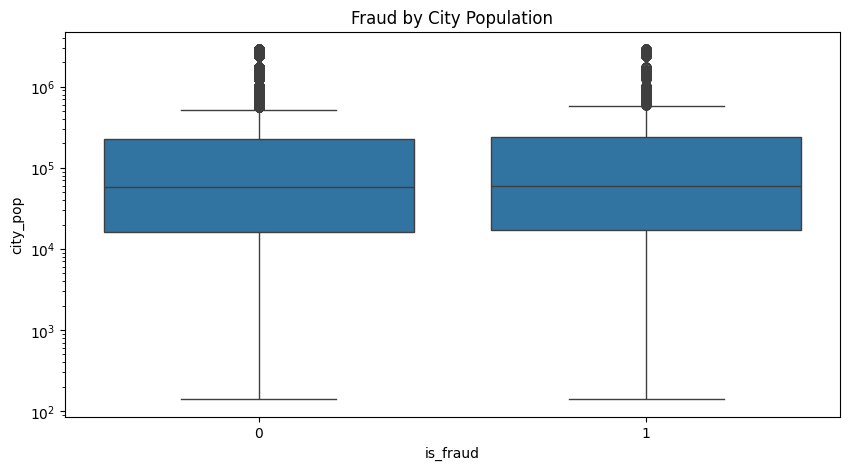

In [13]:
#fraud by city population 

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='is_fraud', y='city_pop')
plt.yscale('log')  # Log scale to handle large population variance
plt.title("Fraud by City Population")
plt.show()

no significant difference in city pop -- both plots show the same median/is exactly the same distribution, city size doesnt correlate with fraud 

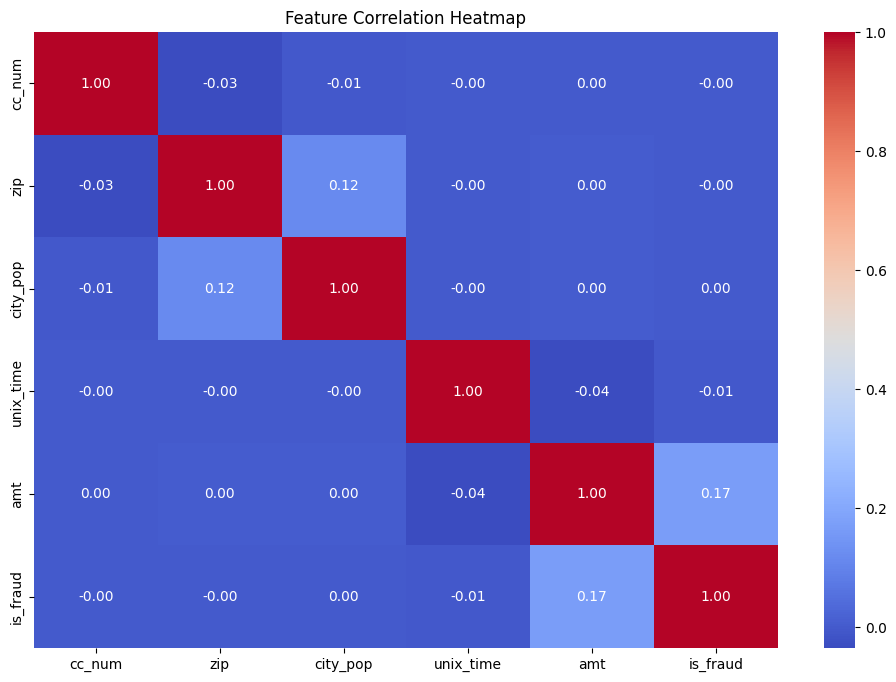

In [14]:
#correlation heat map
df_numeric = df.select_dtypes(include=['number'])

# Create the correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()